In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys

dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path:
    sys.path.append(dir1)

os.chdir('..')

# Take mean scores from standard ensenble, stds - from SGLD ensemble

In [2]:
from utils import metrics
from utils.ensembles import EnsembleCPDModel, CusumEnsembleCPDModel

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, Dataset

import yaml

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload
%matplotlib inline

comet_ml is installed but `COMET_API_KEY` is not set.


In [3]:
class OutputDataset(Dataset):
    """Fake dataset to store pre-computed all models' outputs for MMD model evaluation."""

    def __init__(self, test_out_bank, test_uncertainties_bank, test_labels_bank):
        super().__init__()
        
        # every prediction is (batch_size, seq_len)
        self.test_out = list(torch.vstack(test_out_bank))
                
        self.test_labels = list(torch.vstack(test_labels_bank))
        
        self.test_uncertainties = list(torch.vstack(test_uncertainties_bank))  

    def __len__(self):
        return len(self.test_labels)

    def __getitem__(self, idx):
        return (self.test_out[idx], self.test_uncertainties[idx]), self.test_labels[idx]
    
class AllModelsOutputDataset(Dataset):
    """Fake dataset to store pre-computed all models' outputs for MMD model evaluation."""

    def __init__(self, test_out_bank, test_labels_bank):
        super().__init__()
        
        # every prediction is (n_models, batch_size, seq_len)
        self.test_out = list(torch.hstack(test_out_bank).transpose(0, 1))
                
        self.test_labels = list(torch.vstack(test_labels_bank))
        
    def __len__(self):
        return len(self.test_labels)

    def __getitem__(self, idx):
        return self.test_out[idx], self.test_labels[idx]

## BCE HAR - mean, BCE-SGLD HAR -- std

In [4]:
model_type = "seq2seq"
experiments_name = "human_activity"

path_to_config = "configs/" + experiments_name + "_" + model_type + ".yaml"

with open(path_to_config, 'r') as f:
    args_config = yaml.safe_load(f.read())

args_config["experiments_name"] = experiments_name
args_config["model_type"] = model_type
args_config["loss_type"] = "bce"
args_config["num_workers"] = 2
args_config["learning"]["gpus"] = 1
args_config["learning"]["epochs"] = 100

In [5]:
path_to_models_folder = "saved_models/bce/human_activity/full_sample"

ens_bce = EnsembleCPDModel(args_config, n_models=10, boot_sample_size=None)
ens_bce.load_models_list(path_to_models_folder)

In [6]:
test_dataset = ens_bce.test_dataset
test_dataloader = DataLoader(test_dataset, batch_size = args_config["learning"]["batch_size"], shuffle=False) # NO SHUFFLE

seq_batch, labels_batch = next(iter(test_dataloader))

In [7]:
# collecting outputs
test_out_bank, test_uncertainties_bank, test_labels_bank = metrics.collect_model_predictions_on_set(
    ens_bce,
    test_dataloader,
    model_type="ensemble",
    device="cpu"
)

 10%|▉         | 2/21 [00:00<00:01, 13.18it/s]

Collectting model's outputs


100%|██████████| 21/21 [00:01<00:00, 17.75it/s]


In [8]:
path_to_models_folder_sgld = "saved_models/bce/human_activity/sgld_adam"

ens_bce_sgld = EnsembleCPDModel(args_config, n_models=10, boot_sample_size=None)
ens_bce_sgld.load_models_list(path_to_models_folder_sgld)

In [9]:
# collecting outputs
test_out_bank_sgld, test_uncertainties_bank_sgld, test_labels_bank_sgld = metrics.collect_model_predictions_on_set(
    ens_bce_sgld,
    test_dataloader,
    model_type="ensemble",
    device="cpu"
)

  0%|          | 0/21 [00:00<?, ?it/s]

 10%|▉         | 2/21 [00:00<00:00, 19.98it/s]

Collectting model's outputs


100%|██████████| 21/21 [00:01<00:00, 20.45it/s]


In [10]:
series_batch = test_out_bank[10]
series_std_batch = test_uncertainties_bank[10]
labels_batch = test_labels_bank[10]

In [11]:
# means and stds - from different out banks 
out_dataset = OutputDataset(test_out_bank, test_uncertainties_bank_sgld, test_labels_bank)
out_dataloader = DataLoader(out_dataset, batch_size=128, shuffle=False)

In [42]:
metrics.compute_stds(
    ens_bce_sgld,
    test_dataloader,
    windows_list=[1, 2, 3, 4],
    verbose=True,
    device="cpu"
);

 10%|▉         | 2/21 [00:00<00:01, 16.25it/s]

Computing model's outputs...


100%|██████████| 21/21 [00:01<00:00, 17.82it/s]


Window: 1
CP stds list:
Mean = 0.14856014578333035, number is 1141
Normal stds list:
Mean = 0.13804214436880832, number is 1304
p_val analytical = 8.908505798236434e-10, p_val permutational = 0.0
Stds are not statistically equal
--------------------------------------------------
Window: 2
CP stds list:
Mean = 0.15283507587980744, number is 1141
Normal stds list:
Mean = 0.1382786181552647, number is 1268
p_val analytical = 1.4898405995784072e-17, p_val permutational = 0.0
Stds are not statistically equal
--------------------------------------------------
Window: 3
CP stds list:
Mean = 0.15571617045154915, number is 1141
Normal stds list:
Mean = 0.13875750818722, number is 1224
p_val analytical = 2.0403367025932587e-22, p_val permutational = 0.0
Stds are not statistically equal
--------------------------------------------------
Window: 4
CP stds list:
Mean = 0.15873038092926864, number is 1141
Normal stds list:
Mean = 0.13939830492499133, number is 1173
p_val analytical = 4.4900837999565

## CUSUMs and co

In [12]:
norm_sigma = 0.1382786
cp_sigma = 0.1528351

global_sigma = norm_sigma
lambda_null = 1. / cp_sigma ** 2
lambda_inf = 1. / norm_sigma ** 2
half_wnd = 2

In [13]:
ens_har_sgld_old = CusumEnsembleCPDModel(
    args_config,
    n_models=10,
    global_sigma=global_sigma,
    seed=0,
    cusum_threshold=10,
    cusum_mode="old",
    conditional=True,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd
)
_, cusum_old = ens_har_sgld_old.cusum_detector(series_batch, series_std_batch)

# ----------------------------------------------------------- #

ens_har_sgld_correct_noncond = CusumEnsembleCPDModel(
    args_config,
    n_models=10,
    global_sigma=global_sigma,
    seed=0,
    cusum_threshold=10,
    cusum_mode="correct",
    conditional=False,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
)
cusum_correct_noncond = ens_har_sgld_correct_noncond.cusum_detector(series_batch, series_std_batch)[1].detach().cpu()

# ----------------------------------------------------------- #

ens_har_sgld_correct_cond = CusumEnsembleCPDModel(
    args_config,
    n_models=10,
    global_sigma=global_sigma,
    seed=0,
    cusum_threshold=10,
    cusum_mode="correct",
    conditional=True,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
)
cusum_correct_cond = ens_har_sgld_correct_cond.cusum_detector(series_batch, series_std_batch)[1].detach().cpu()

# ----------------------------------------------------------- #

ens_har_sgld_new_crit_noncond = CusumEnsembleCPDModel(
    args_config,
    n_models=10,
    global_sigma=global_sigma,
    seed=0,
    cusum_threshold=10,
    cusum_mode="new_criteria",
    conditional=False,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
)
new_crit_noncond = ens_har_sgld_new_crit_noncond.new_scores_aggregator(series_batch, series_std_batch)[1].detach().cpu()

# ----------------------------------------------------------- #

ens_har_sgld_new_crit_cond = CusumEnsembleCPDModel(
    args_config,
    n_models=10,
    global_sigma=global_sigma,
    seed=0,
    cusum_threshold=10,
    cusum_mode="new_criteria",
    conditional=True,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
)
new_crit_cond = ens_har_sgld_new_crit_cond.new_scores_aggregator(series_batch, series_std_batch)[1].detach().cpu()

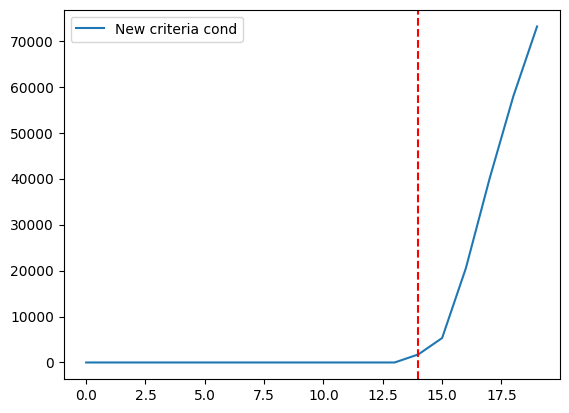

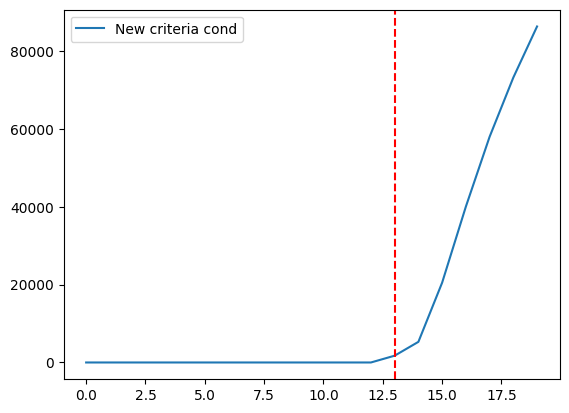

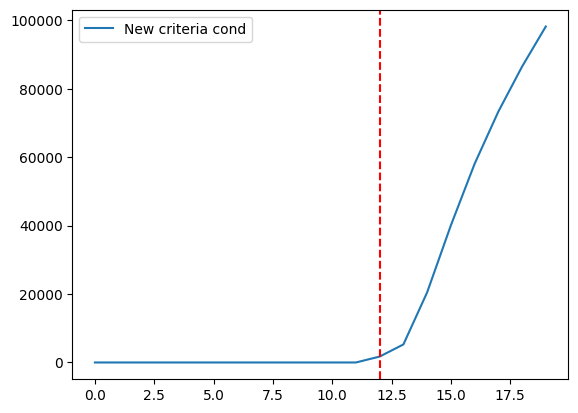

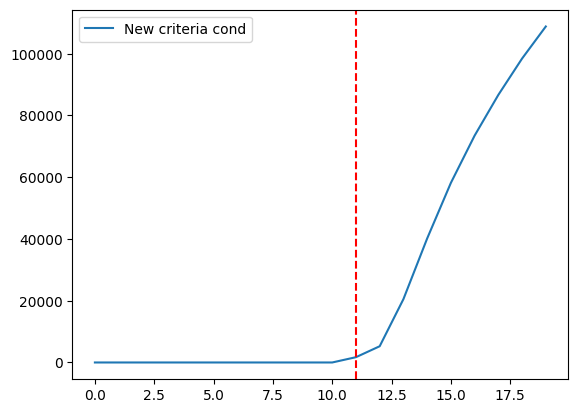

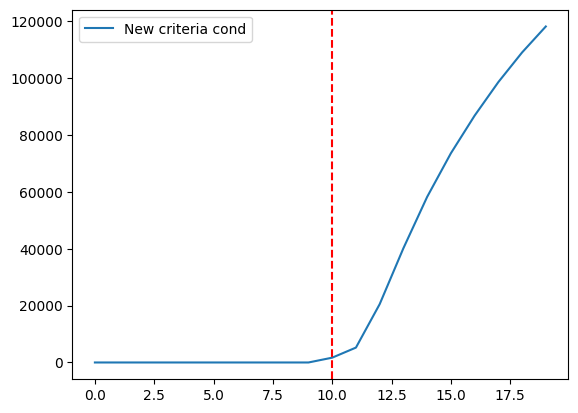

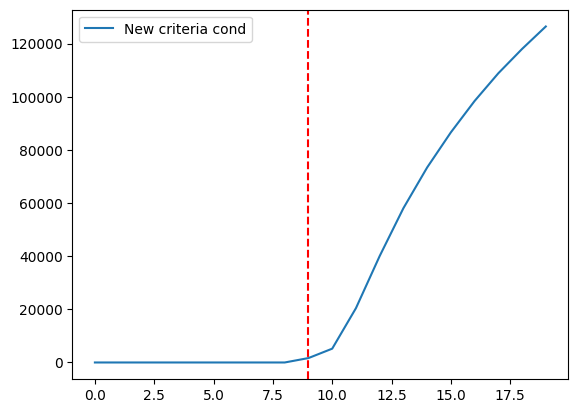

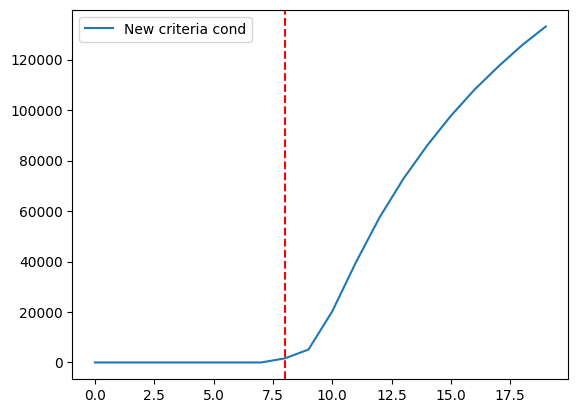

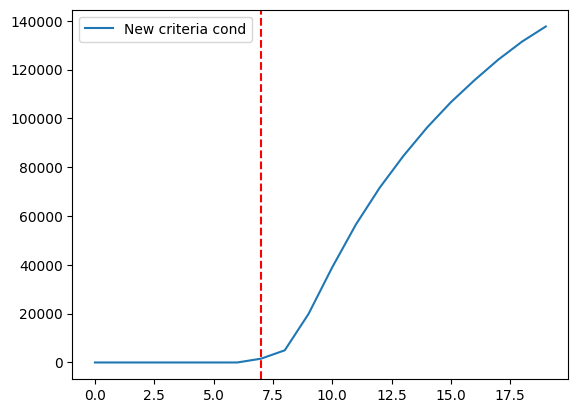

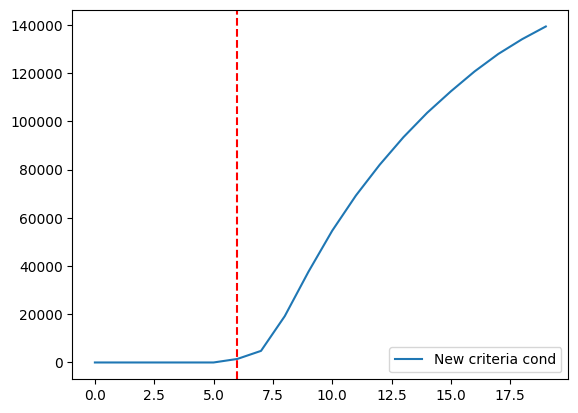

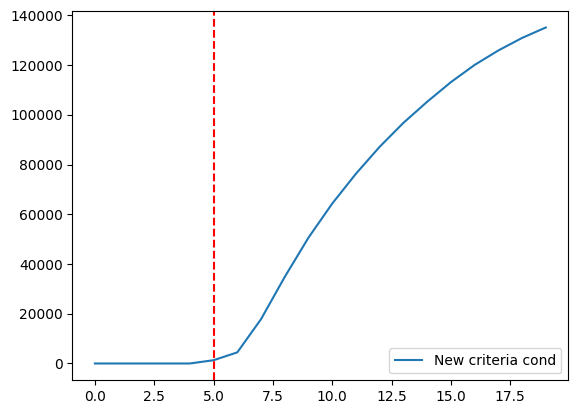

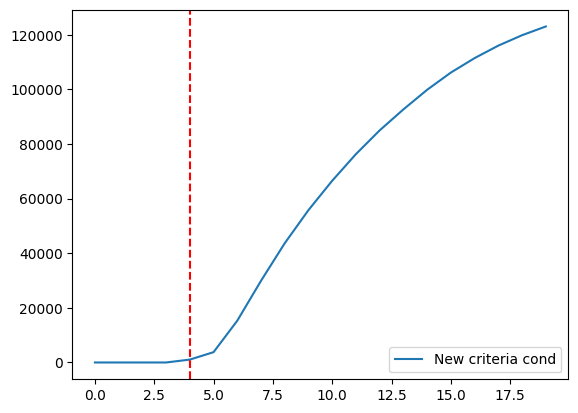

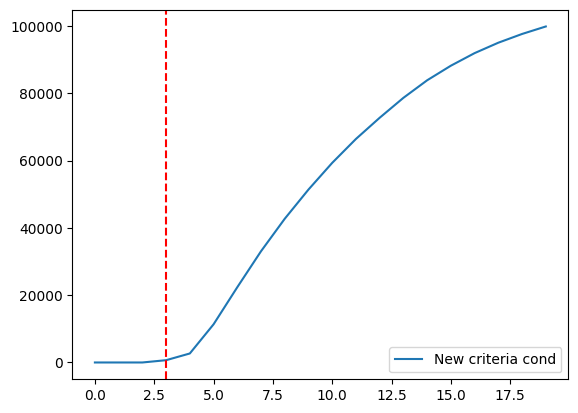

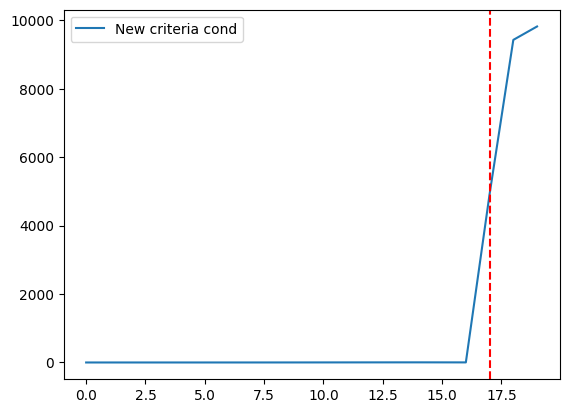

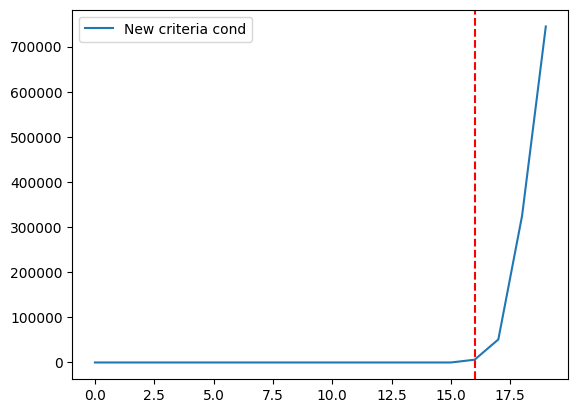

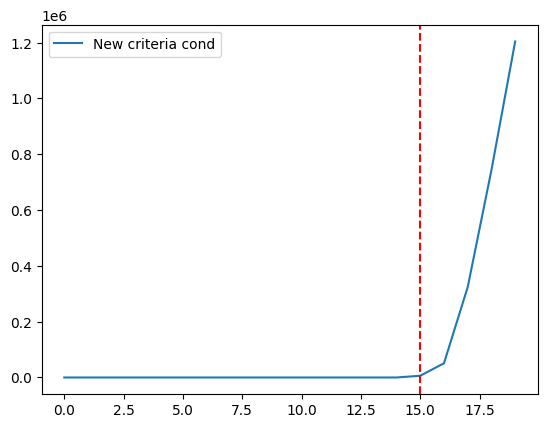

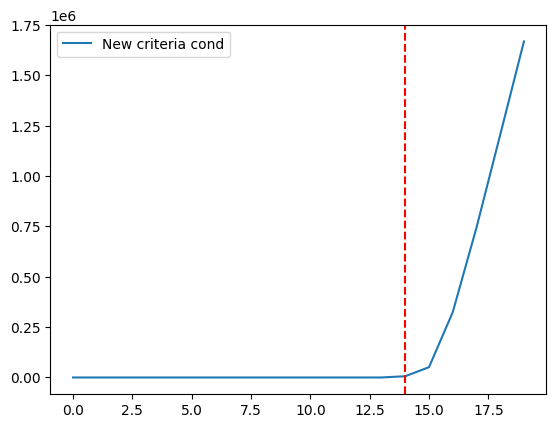

In [17]:
for IDX in range(16):
    change_idx = labels_batch[IDX].detach().cpu().numpy().argmax()

    plt.figure()
    #plt.plot(cusum_old[IDX], label="Old CUSUM")
    #plt.plot(cusum_correct_noncond[IDX], label="Correct CUSUM non-cond")
    #plt.plot(cusum_correct_cond[IDX], label="New CUSUM cond")
    #plt.plot(new_crit_noncond[IDX], label="New criteria non-cond")
    plt.plot(new_crit_cond[IDX], label="New criteria cond")

    if change_idx > 0:
        plt.axvline(x = change_idx, c="red", linestyle="--")
    plt.legend()
    plt.show()

In [18]:
cusum_threshold_list = np.linspace(0, 300, 200)

metrics.evaluate_cusum_ensemble_model(
    cusum_threshold_list=cusum_threshold_list,
    output_dataloader=out_dataloader,
    margin_list=[1, 2, 4],
    args_config=args_config,
    n_models=10,
    save_path=path_to_models_folder,
    cusum_mode="old",
    conditional=True,
    global_sigma=global_sigma,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
    device="cpu",
    verbose=True,
);

100%|██████████| 200/200 [06:59<00:00,  2.10s/it]

Results for best threshold = 3.0150753768844223
AUDC: 0.0, Time to FA: 11.2835, DD: 0.3224, F1: 0.9799, Cover: 0.9923, Max Cover: 0.9923
Max F1 with margin 1: 0.9795
Max F1 with margin 2: 0.9804
Max F1 with margin 4: 0.9817


In [20]:
cusum_threshold_list = np.linspace(0, 500, 200)

metrics.evaluate_cusum_ensemble_model(
    cusum_threshold_list=cusum_threshold_list,
    output_dataloader=out_dataloader,
    margin_list=[1, 2, 4],
    args_config=args_config,
    n_models=10,
    save_path=path_to_models_folder,
    cusum_mode="correct",
    conditional=False,
    global_sigma=global_sigma,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
    device="cpu",
    verbose=True,
);

100%|██████████| 200/200 [07:02<00:00,  2.11s/it]

Results for best threshold = 5.025125628140704
AUDC: 0.0, Time to FA: 11.08, DD: 0.1099, F1: 0.9935, Cover: 0.9939, Max Cover: 0.9939
Max F1 with margin 1: 0.9874
Max F1 with margin 2: 0.99
Max F1 with margin 4: 0.9931


In [21]:
cusum_threshold_list = np.linspace(0, 100000, 200)

metrics.evaluate_cusum_ensemble_model(
    cusum_threshold_list=cusum_threshold_list,
    output_dataloader=out_dataloader,
    margin_list=[1, 2, 4],
    args_config=args_config,
    n_models=10,
    save_path=path_to_models_folder,
    cusum_mode="correct",
    conditional=True,
    global_sigma=global_sigma,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
    device="cpu",
    verbose=True,
);

100%|██████████| 200/200 [06:52<00:00,  2.06s/it]

Results for best threshold = 0.0
AUDC: 0.0, Time to FA: 11.0262, DD: 0.0935, F1: 0.9909, Cover: 0.9938, Max Cover: 0.9938
Max F1 with margin 1: 0.9865
Max F1 with margin 2: 0.9896
Max F1 with margin 4: 0.9914


In [22]:
cusum_threshold_list = np.linspace(0, 500, 200)

metrics.evaluate_cusum_ensemble_model(
    cusum_threshold_list=cusum_threshold_list,
    output_dataloader=out_dataloader,
    margin_list=[1, 2, 4],
    args_config=args_config,
    n_models=10,
    save_path=path_to_models_folder,
    cusum_mode="new_criteria",
    conditional=False,
    global_sigma=global_sigma,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
    device="cpu",
    verbose=True,
);

100%|██████████| 200/200 [06:49<00:00,  2.05s/it]

Results for best threshold = 15.075376884422113
AUDC: 0.0, Time to FA: 11.1017, DD: 0.1683, F1: 0.9931, Cover: 0.9894, Max Cover: 0.9894
Max F1 with margin 1: 0.9861
Max F1 with margin 2: 0.9883
Max F1 with margin 4: 0.9918


In [23]:
cusum_threshold_list = np.linspace(0, 100000, 200)

metrics.evaluate_cusum_ensemble_model(
    cusum_threshold_list=cusum_threshold_list,
    output_dataloader=out_dataloader,
    margin_list=[1, 2, 4],
    args_config=args_config,
    n_models=10,
    save_path=path_to_models_folder,
    cusum_mode="new_criteria",
    conditional=True,
    global_sigma=global_sigma,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
    device="cpu",
    verbose=True,
);

100%|██████████| 200/200 [06:57<00:00,  2.09s/it]

Results for best threshold = 0.0
AUDC: 0.0, Time to FA: 0.982, DD: 0.018, F1: 0.0818, Cover: 0.6562, Max Cover: 0.6562
Max F1 with margin 1: 0.1301
Max F1 with margin 2: 0.1859
Max F1 with margin 4: 0.3097


In [24]:
cusum_threshold_list = np.linspace(0, 100, 50)

metrics.evaluate_cusum_ensemble_model(
    cusum_threshold_list=cusum_threshold_list,
    output_dataloader=out_dataloader,
    margin_list=[1, 2, 4],
    args_config=args_config,
    n_models=10,
    save_path=path_to_models_folder,
    cusum_mode="new_criteria",
    conditional=True,
    global_sigma=global_sigma,
    lambda_null=lambda_null,
    lambda_inf=lambda_inf,
    half_wnd=half_wnd,
    device="cpu",
    verbose=True,
);

100%|██████████| 50/50 [01:44<00:00,  2.09s/it]

Results for best threshold = 8.16326530612245
AUDC: 0.0, Time to FA: 11.0703, DD: 0.1429, F1: 0.9918, Cover: 0.9909, Max Cover: 0.9909
Max F1 with margin 1: 0.9839
Max F1 with margin 2: 0.9874
Max F1 with margin 4: 0.9901
